In [3]:
import os
import numpy as np
import copy
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from marvin.tools import Maps
from marvin import config
import marvin.utils.plot.map as mapplot
from marvin.tools.image import Image

In [4]:
# These functions come from the manga_flipping_funct.py file
from manga_flipping_funct import snr_mask, flip_map, disk

In [5]:
# set the cosmology for converting between angular size to physical size at a given redshift
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

In [6]:
targets = np.loadtxt("/home/idies/workspace/Storage/adiamond/persistent/bgl_manga/plateifu_csv_files/top10.csv", delimiter=',', dtype=str)
targets = targets[1:]

#### Note if you try to run this file not in a "Marvin" container, you will get an error when trying to retrieve the nsa values because for some reason the drpall file is only accessable in Marvin containers 

In [7]:
# Used for debugging
maps = Maps(plateifu=targets[1], bintype='HYB10')
snr_minimum = 3.

# Creating flux maps
ha = maps.emline_gflux_ha_6564
mask_ha_flux = snr_mask(ha, snr_minimum)

# [nII]/Ha
nii = maps.emline_gflux_nii_6585
nii_ha = nii/ha
mask_nii_ha = mask_ha_flux | snr_mask(nii, snr_minimum)

# [oiii]/Hb
hb = maps.emline_gflux_hb_4862 
oiii_5008 = maps.emline_gflux_oiii_5008
oiii_hb = oiii_5008/hb
mask_oiii_hb = snr_mask(hb, snr_minimum) | snr_mask(oiii_5008, snr_minimum)

/home/idies/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f89d9339e48>)

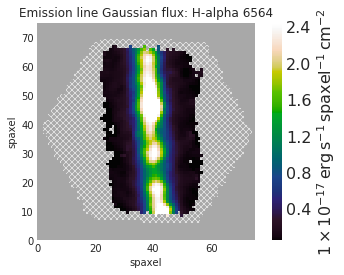

In [8]:
ha.plot()

In [9]:
# Ha vel dispersion, velocity, stellar vel, 
ha_sig = maps.emline_gsigma_ha_6564
ha_vel = maps.emline_gvel_ha_6564
stvel = maps.stellar_vel


# Ha velocity - stellar velocity map
diff = copy.deepcopy(stvel)
diff.value[:,:] = ha_vel.value - stvel.value
diff.ivar = 1. / ((1. / ha_vel.ivar) + (1. / stvel.ivar))
diff.mask = ha_vel.mask | stvel.mask | mask_ha_flux
diff.property_name = 'Ha vel - stellar vel'

/home/idies/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [10]:
# Flipped Maps 
flipped_vel, flip_flux_mask, asymmetry, major_axis = flip_map(maps, ha_vel, ha, snr_minimum)

/home/idies/miniconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/home/idies/workspace/Storage/adiamond/persistent/github/bates_galaxies_lab/manga/manga_flipping_funct.py:118: RuntimeWarning: divide by zero encountered in true_divide
  asymm_map.ivar = 1. / ((1. / original_map.ivar) + (1. / flipped_map.ivar))


In [11]:
maps.nsa.z

0.029649716

In [12]:
filename = 'ad_sciserver_map_trial.pdf'

In [13]:
with PdfPages(filename) as pdf:
    for i in range(3): #len(targets)):
        print(str(targets[i]))
        try:
            maps = Maps(plateifu=targets[i], bintype='HYB10', template='GAU-MILESHC')
            snr_minimum = 3.

            # Creating flux maps
            ha = maps.emline_gflux_ha_6564
            mask_ha_flux = snr_mask(ha, snr_minimum)

            # [nII]/Ha
            nii = maps.emline_gflux_nii_6585
            nii_ha = nii/ha
            mask_nii_ha = mask_ha_flux | snr_mask(nii, snr_minimum)

            # [oiii]/Hb
            hb = maps.emline_gflux_hb_4862 
            oiii_5008 = maps.emline_gflux_oiii_5008
            oiii_hb = oiii_5008/hb
            mask_oiii_hb = snr_mask(hb, snr_minimum) | snr_mask(oiii_5008, snr_minimum)


            # Ha vel dispersion, velocity, stellar vel, 
            ha_sig = maps.emline_gsigma_ha_6564
            ha_vel = maps.emline_gvel_ha_6564
            stvel = maps.stellar_vel


            # Ha velocity - stellar velocity map
            diff = copy.deepcopy(stvel)
            diff.value[:,:] = ha_vel.value - stvel.value
            diff.ivar = 1. / ((1. / ha_vel.ivar) + (1. / stvel.ivar))
            diff.mask = ha_vel.mask | stvel.mask | mask_ha_flux
            diff.property_name = 'Ha vel - stellar vel'

            # Flipped Maps 
            flipped_vel, flip_flux_mask, asymmetry, major_axis = flip_map(maps, ha_vel, ha, snr_minimum)


            #Plotting
            fig = plt.figure(constrained_layout=False, figsize=(25,20))
            spec = gridspec.GridSpec(ncols=4, nrows=3, figure=fig,  hspace=0.2)

            #(0,0) IMAGE 
            ax1 = fig.add_subplot(spec[0,0])
            im = Image(targets[i], download=False)
            ax1.imshow(im.data)
        #         plt.grid(None)
            ax1.set_title(str(targets[i]))

            #(0,1) FLUX 
            ax2 = fig.add_subplot(spec[0,1])
            flux = Maps(plateifu=targets[i]).emline_gflux_ha_6564
            flux.plot(fig=fig, ax=ax2, snr_min=0)

            #(0,2) 1 re size disk cutout
            ax3 = fig.add_subplot(spec[0,2])
            ha_vel_copy = copy.deepcopy(ha_vel)
            ha_vel_copy[disk(maps, ha_vel, disk_re_size=1.)] = 0 
            ha_vel_copy.plot(fig=fig, ax=ax3, mask=mask_ha_flux, title=r'$H_\alpha with disk= 1.0 re$')

            #(0,3) 2 re size disk cutout
            ax4 = fig.add_subplot(spec[0,3])
            ha_vel_copy[disk(maps, ha_vel, disk_re_size=1.5)] = 0
            ha_vel_copy.plot(fig=fig, ax=ax4, mask=mask_ha_flux, title=r'$H_\alpha with disk= 1.5 re$')


            #(1,0) Hα VELOCITY
            ax5 = fig.add_subplot(spec[1, 0])
            ha_vel[np.where(major_axis)] = 0
            ha_vel.plot(fig=fig, ax=ax5, mask=mask_ha_flux, title=r'$H_\alpha$')


            #(1,1) Hα FLIPPED VELOCITY
            ax6 = fig.add_subplot(spec[1, 1])
            flipped_vel.plot(fig=fig, ax=ax6, title='Ha vel 6564 Flip', mask=flip_flux_mask)

            #(1,2) ASYMMETRY 
            ax7 = fig.add_subplot(spec[1, 2])
            asymmetry.plot(fig=fig, ax=ax7, title='Ha vel 6564 Asymmetry',mask=asymmetry.mask)

            #(1,3) VELOCITY DISPERSION
            ax8 = fig.add_subplot(spec[1, 3])
            ha_sig.plot(fig=fig, ax=ax8, mask=mask_ha_flux)

            #(2,0) STELLAR VELOCITY
            ax9 = fig.add_subplot(spec[2, 0])
            stvel.plot(fig=fig, ax=ax9, mask=mask_ha_flux)

            #(2,1) VELOCITY - STELLAR VELOCITY
            ax10 = fig.add_subplot(spec[2, 1])
            diff.plot(fig=fig, ax=ax10, title='Ha vel - stellar vel')

            #(2,2) Nii/Ha
            ax11 = fig.add_subplot(spec[2, 2])
            nii_ha.plot(fig=fig, ax=ax11, title='[NII]/Ha', mask=mask_nii_ha)

            #(2,3) Oiii/Hb
            ax12 = fig.add_subplot(spec[2, 3])
            oiii_hb.plot(fig=fig, ax=ax12, title='[oiii 5008]/Hb',  mask=mask_oiii_hb)


            fig.tight_layout()

            pdf.savefig(facecolor=fig.get_facecolor(), edgecolor='none')
            plt.close()

        except:
            print('error')
            pass
#os.system("open %s &" % filename)

10220-6104
error
7960-12702


/home/idies/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/home/idies/miniconda3/lib/python3.7/socket.py:660: ResourceWarning: unclosed <socket.socket fd=56, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.17.0.13', 45848), raddr=('155.101.19.23', 443)>
  self._sock = None
/home/idies/miniconda3/lib/python3.7/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in multiply
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/home/idies/miniconda3/lib/python3.7/site-packages/marvin/utils/plot/map.py:111: RuntimeWarning: invalid value encountered in less
  low_snr[np.abs(value * np.sqrt(ivar)) < snr_min] = True
/home/idies/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes t

7960-6103
